In [28]:
import cv2
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Polygon, MultiPolygon
from skimage.measure import find_contours
from skimage.segmentation import slic, mark_boundaries

### team 4 contours

In [2]:
def extract_outline(image_path):
        image = cv2.imread(image_path)
        image_name = os.path.basename(image_path)
        
        # Converting to grayscale
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Enhance contrast to improve contour accuracy
        image_gray = cv2.equalizeHist(image_gray)

        # Converting to grayscale
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Enhance contrast to improve contour accuracy
        image_gray = cv2.equalizeHist(image_gray)

        # Blurring the image to reduce noise
        blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)
        
        if 'melan' in image_name:
            adaptive_thresholding = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 1)
        elif 'sox10' in image_name:
            adaptive_thresholding = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 13, 1)
        else: 
            # Adaptive thresholding used to seperate foreground objects from the background
            adaptive_thresholding = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY, 13, 1.8)

        # Find initial contours and create binary mask
        contours, _ = cv2.findContours(adaptive_thresholding, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        mask = np.zeros_like(adaptive_thresholding)
        cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

        # Blurring to reduce noise
        blurred_thresh = cv2.boxFilter(adaptive_thresholding, -1, (111, 111))
        
        # Create a mask for non-white areas directly from the binary image
        lower_white = 200 
        mask_binary = blurred_thresh > lower_white
        
        # Convert the boolean mask to a binary mask so it saves in the correct form
        mask_binary_image = (mask_binary.astype(np.uint8) * 255)

        return mask_binary_image

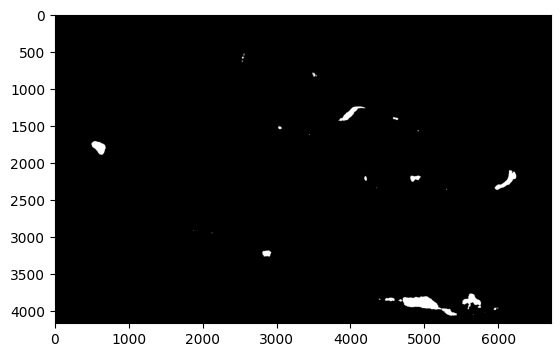

In [3]:
image_path = './h1849462/h&e_ROI_3.tif'  # Replace with the actual image path
he_mask = extract_outline(image_path)
plt.imshow(he_mask, cmap='gray')  

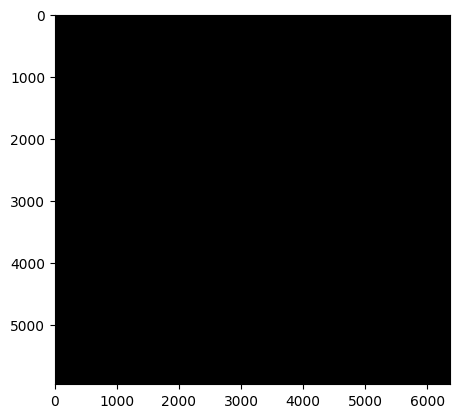

In [4]:
image_path = './h1849462/melan a_ROI_1.tif'  # Replace with the actual image path
melana_mask = extract_outline(image_path)
plt.imshow(melana_mask, cmap='gray')  

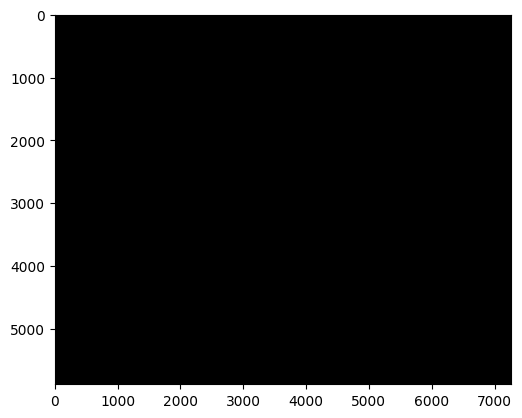

In [5]:
image_path = './h1849462/sox10_ROI_1.tif'  # Replace with the actual image path
sox_mask = extract_outline(image_path)
plt.imshow(sox_mask, cmap='gray')  

### rotating geojsons

In [6]:
# Function to get Shapely polygon from geojson
def get_polygon(geojson_path):
    gdf = gpd.read_file(geojson_path)
    polygon = gdf.geometry.values[0]  
    
    if isinstance(polygon, MultiPolygon):
        polygon = max(polygon.geoms, key=lambda p: p.area)  
        return polygon

    if isinstance(polygon, Polygon):
        return polygon
    
# Function to scale polygons and align them by translating their bounding boxes to (0,0)
def align(polygons):
    # Step 1: Calculate the bounding boxes for all polygons
    bounding_boxes = [poly.bounds for poly in polygons]
    
    # Step 2: Find the max width and max height across all polygons (to scale)
    max_width = max([maxx - minx for minx, miny, maxx, maxy in bounding_boxes])
    max_height = max([maxy - miny for minx, miny, maxx, maxy in bounding_boxes])
    
    scaled_polygons = []
    translated_polygons = []
    
    # Step 3: Scale each polygon to match the largest bounding box and translate to (0, 0)
    for poly in polygons:
        minx, miny, maxx, maxy = poly.bounds
        poly_width = maxx - minx
        poly_height = maxy - miny
        
        # Compute scale factors for width and height
        scale_x = max_width / poly_width
        scale_y = max_height / poly_height
        
        # Compute the center of the polygon
        centroid = poly.centroid
        cx, cy = centroid.x, centroid.y
        
        # Step 4: Scale the polygon coordinates
        scaled_coords = []
        for coord in poly.exterior.coords:
            x, y = coord
            x_scaled = (x - cx) * scale_x + cx
            y_scaled = (y - cy) * scale_y + cy
            scaled_coords.append((x_scaled, y_scaled))
        
        scaled_poly = Polygon(scaled_coords)
        scaled_polygons.append(scaled_poly)
        
        # Step 5: Translate the scaled polygon so its bounding box starts at (0, 0)
        minx, miny, maxx, maxy = scaled_poly.bounds
        translation_x = -minx
        translation_y = -miny
        
        translated_coords = [(x + translation_x, y + translation_y) for x, y in scaled_poly.exterior.coords]
        translated_poly = Polygon(translated_coords)
        translated_polygons.append(translated_poly)
    
    return translated_polygons

def plot_polygons(polygons, labels=None, title="Polygons"):
    plt.figure(figsize=(8, 8))
    
    # Loop through each polygon and its corresponding label
    for i, poly in enumerate(polygons):
        # Plot the polygon itself
        x, y = poly.exterior.xy
        label = labels[i] if labels else f"Polygon {i+1}"
        plt.plot(x, y, label=label)
        
        # Compute the bounding box
        minx, miny, maxx, maxy = poly.bounds
        # Plot the bounding box (as a rectangle)
        plt.plot([minx, maxx], [miny, miny], color='r', linestyle='--', linewidth=2)  # Bottom edge
        plt.plot([maxx, maxx], [miny, maxy], color='r', linestyle='--', linewidth=2)  # Right edge
        plt.plot([maxx, minx], [maxy, maxy], color='r', linestyle='--', linewidth=2)  # Top edge
        plt.plot([minx, minx], [maxy, miny], color='r', linestyle='--', linewidth=2)  # Left edge
    
    # Set plot title and axis equal for correct aspect ratio
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

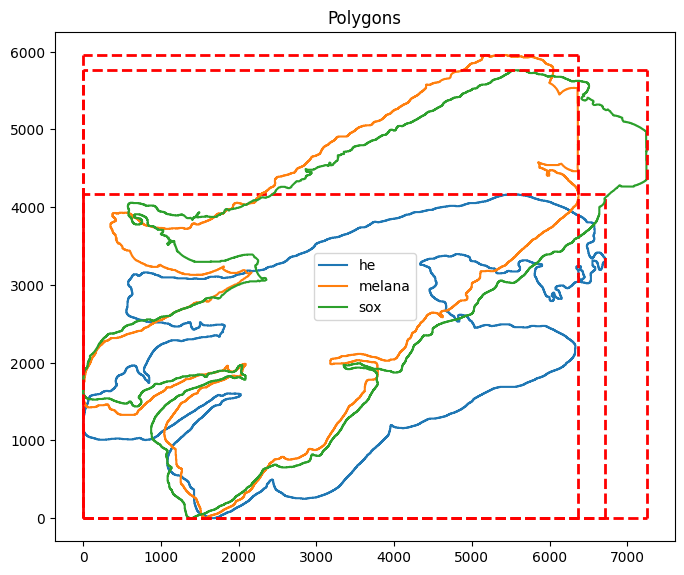

In [7]:
paths = ['geojsons2/h&e_ROI_3.geojson', 'geojsons2/melan a_ROI_1.geojson', 'geojsons2/sox10_ROI_1.geojson']
polygons = [get_polygon(path) for path in paths]
plot_polygons(polygons, labels=['he', 'melana', 'sox'])

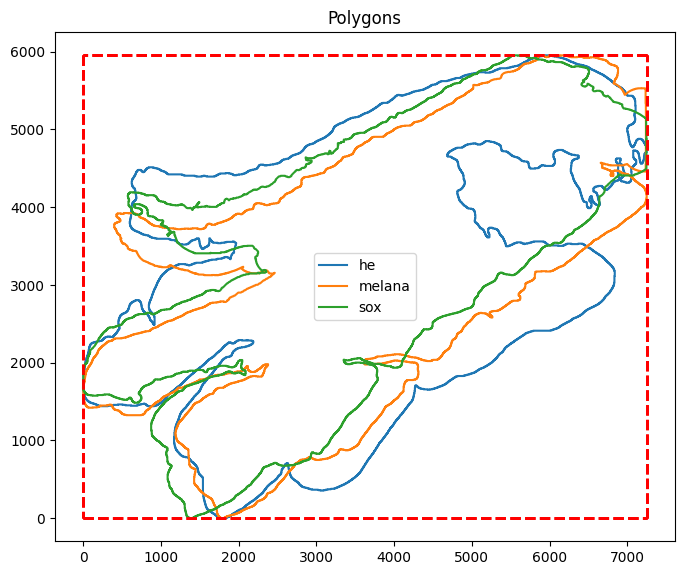

In [8]:
aligned_polygons = align(polygons)
plot_polygons(aligned_polygons, labels=['he', 'melana', 'sox'])

attempted methods:
- Procrustes Analysis (probably needs to resample points)
- Iterative Closest Point (ICP) Algorithm (kernel kept shutting down)
- Keypoint Detection (probably needs to resample points)
- Centroids (didn't align tissues well)
- Hu Moments (didn't change anything)

### rotating tif masks

In [22]:
# clean edges using morphological operations
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    dilated = cv2.dilate(blurred, np.ones((3, 3), np.uint8), iterations=1)
    cleaned_edges = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
    return cleaned_edges

# find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# center the image based on center of mass (centering in both axes)
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# COMBINES ABOVE FUNCTIONS
def pipeline_helper(tif_path):
    image = cv2.imread(tif_path, 0)
    edges = cv2.Canny(image, 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)
    mask = fill_contour(cleaned_edges.shape, largest_contour)
    centered_mask = center_image(mask)
    return centered_mask

In [41]:
# rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    # Check the number of dimensions in the image
    if len(image.shape) == 2:
        # Grayscale image (2D)
        h, w = image.shape
    elif len(image.shape) == 3:
        # Color image (3D)
        h, w, c = image.shape  # c is the number of channels (e.g., 3 for RGB)
    else:
        raise ValueError("Unsupported image dimensions")

    # Calculate padding
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left

    # Apply padding
    if len(image.shape) == 2:
        # Grayscale image padding (2D)
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
    elif len(image.shape) == 3:
        # Color image padding (3D)
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
    
    return padded_image

# find the best rotation that maximizes overlap
def find_best_rotation(mask1, mask2, angles=np.arange(-30, 31, 1)):  # Restrict rotation range from -30° to +30°
    best_overlap = 0
    best_angle = 0
    for angle in angles:
        rotated_mask2 = rotate_image(mask2, angle)
        intersection = cv2.bitwise_and(mask1, rotated_mask2)
        union = cv2.bitwise_or(mask1, rotated_mask2)
        similarity_score = np.sum(intersection) / np.sum(union)
        
        if similarity_score > best_overlap:
            best_overlap = similarity_score
            best_angle = angle
    
    return best_overlap, best_angle

In [24]:
# FOR THREE MASKS
def pipeline(path1, path2, path3):
    mask1 = pipeline_helper(path1)
    mask2 = pipeline_helper(path2)
    mask3 = pipeline_helper(path3)

    # Step 1: Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1], mask3.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0], mask3.shape[0])

    # Step 2: Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))
    mask3 = pad_to_size(mask3, (max_width, max_height))

    # Step 3: Find the best rotation for mask2 that maximizes overlap with mask1
    best_overlap_2, angle2 = find_best_rotation(mask1, mask2)
    mask2_rotated = rotate_image(mask2, angle2)

    # Step 4: Find the best rotation for mask3 that maximizes overlap with the rotated mask2
    best_overlap_3, angle3 = find_best_rotation(mask1, mask3)
    mask3_rotated = rotate_image(mask3, angle3)

    # Step 5: Calculate the final similarity score for all three masks
    # intersection = cv2.bitwise_and(mask1, rotated_mask2, rotated_mask3)
    # union = cv2.bitwise_or(mask1, rotated_mask2, rotated_mask3)
    # final_similarity_score = np.sum(intersection) / np.sum(union)

    return mask1, mask2, mask3, mask2_rotated, mask3_rotated, angle2, angle3 

In [25]:
paths = ['h1849462/h&e_ROI_3.tif', 'h1849462/melan a_ROI_1.tif', 'h1849462/sox10_ROI_1.tif']
he, melana, sox, melana_rotated, sox_rotated, angle2, angle3  = pipeline(paths[0], paths[1], paths[2])

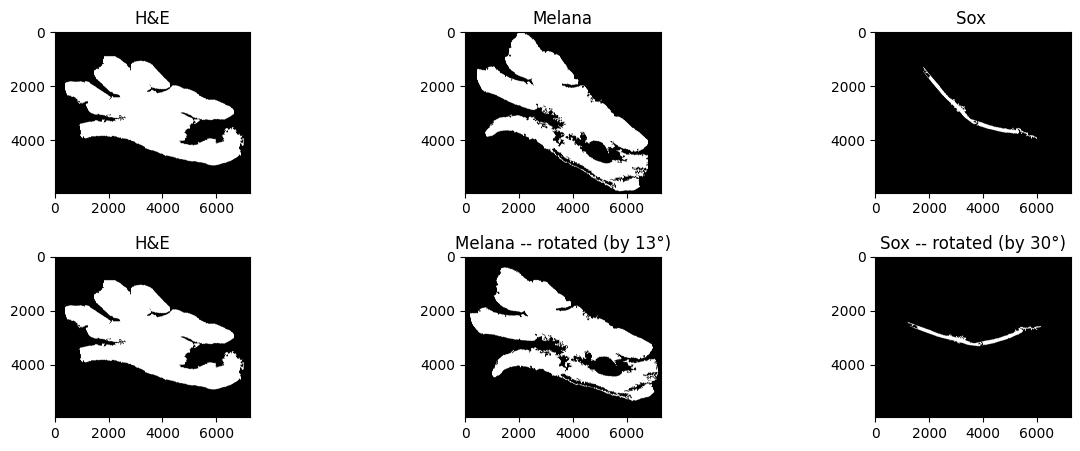

In [26]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 3, 1)
plt.title('H&E')
plt.imshow(he, cmap='gray')

plt.subplot(2, 3, 2)
plt.title(f'Melana')
plt.imshow(melana, cmap='gray')

plt.subplot(2, 3, 3)
plt.title(f'Sox ')
plt.imshow(sox, cmap='gray')

plt.subplot(2, 3, 4)
plt.title('H&E')
plt.imshow(he, cmap='gray')

plt.subplot(2, 3, 5)
plt.title(f'Melana -- rotated (by {angle2}°)')
plt.imshow(melana_rotated, cmap='gray')

plt.subplot(2, 3, 6)
plt.title(f'Sox -- rotated (by {angle3}°)')
plt.imshow(sox_rotated, cmap='gray')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.show()

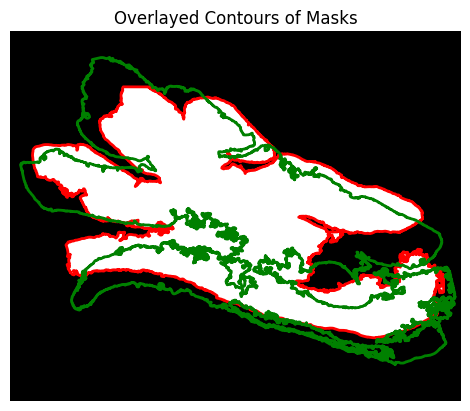

In [27]:
# Find contours for each mask
he_contours = find_contours(he, level=0.5)
melana_contours = find_contours(melana_rotated, level=0.5)
sox_contours = find_contours(sox_rotated, level=0.5)

# Plot the base image (you can choose to use one of the images or any other background)
plt.imshow(he, cmap='gray')  # Replace `he` with the desired base image

# Plot contours of each mask on top of the base image
for contour in he_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red', lw=2)  # Red contours for H&E

for contour in melana_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='green', lw=2)  # Green contours for melana

# Customize plot (optional)
plt.title('Overlayed Contours of Masks')
plt.axis('off')  # Hide axis
plt.show()

### rotating tif masks (he epithelium)

In [29]:
def generate_epithelium_mask(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (45, 45), 0)

    _, thresholded_mask = cv2.threshold(blurred_image, 200, 255, cv2.THRESH_BINARY_INV)
    kernel_huge = np.ones((45, 45), np.uint8)
    cleaned_mask = cv2.morphologyEx(thresholded_mask, cv2.MORPH_CLOSE, kernel_huge)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel_huge)

    kernel_medium = np.ones((25, 25), np.uint8)
    generalized_cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel_medium)
    generalized_cleaned_mask = cv2.morphologyEx(generalized_cleaned_mask, cv2.MORPH_OPEN, kernel_medium)

    # Find contours for the generalized mask
    contours, _ = cv2.findContours(generalized_cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a separate mask
    contour_mask = np.zeros_like(generalized_cleaned_mask)
    cv2.drawContours(contour_mask, contours, -1, 255, thickness=cv2.FILLED)
    
    # Draw a red outline
    contoured_image = image.copy()
    cv2.drawContours(contoured_image, contours, -1, (0, 0, 255), 8)  # Draw red contours
    
    return contour_mask, contours, image

def create_and_cut_superpixels(image, contour_mask, contours, num_segments=750):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Generate and display superpixels
    segments = slic(image_rgb, n_segments=num_segments, compactness=10, start_label=1)
    segmented_image = np.zeros_like(image_rgb)
    lower_purple = np.array([125, 40, 40])
    upper_purple = np.array([155, 255, 255])

    for segment_value in np.unique(segments):
        segment_mask = (segments == segment_value)
        
        # Separate parts inside and outside the contour using the contour mask
        inside_mask = np.logical_and(segment_mask, contour_mask > 0)
        outside_mask = np.logical_and(segment_mask, contour_mask == 0)

        # Process inside region
        if np.sum(inside_mask) > 0:
            inside_segment = np.zeros_like(image_rgb)
            inside_segment[inside_mask] = image_rgb[inside_mask]
            inside_hsv = cv2.cvtColor(inside_segment, cv2.COLOR_RGB2HSV)
            purple_inside_mask = cv2.inRange(inside_hsv, lower_purple, upper_purple)
            
            # Calculate purple concentration inside
            total_pixels_inside = np.sum(inside_segment[:, :, 0] > 0)
            purple_pixels_inside = np.sum(purple_inside_mask > 0)
            purple_concentration_inside = purple_pixels_inside / total_pixels_inside if total_pixels_inside > 0 else 0

            # Assign colors based on purple concentration for inside
            if purple_concentration_inside > 0.15:
                segmented_image[inside_mask] = image_rgb[inside_mask]
            elif purple_concentration_inside > 0.015:
                segmented_image[inside_mask] = [255, 255, 255]
            else:
                segmented_image[inside_mask] = [0, 0, 0]

        # Process outside region (background)
        if np.sum(outside_mask) > 0:
            segmented_image[outside_mask] = [0, 0, 0]  # Assign black to outside background

    # Display the final segmented image with contour overlay
    plt.figure(figsize=(10, 10))
    plt.imshow(segmented_image)
    plt.title("Final Segmented Epithelium Image with Contour-Based Cuts")
    plt.axis('off')
    plt.show()
    
    return segmented_image

# Combining Team 6's code with Team 2's code
def combined_contour_superpixel_segmentation(image_path):
    contour_mask, contours, original_image = generate_epithelium_mask(image_path)
    segmented_image = create_and_cut_superpixels(original_image, contour_mask, contours)
    return segmented_image

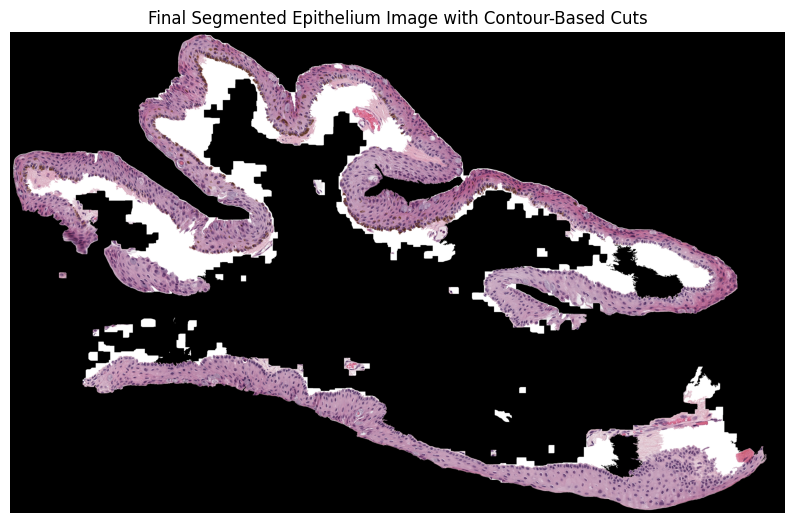

In [49]:
he_ep = combined_contour_superpixel_segmentation('h1849462/h&e_ROI_3.tif')

In [50]:
def color_image_to_binary_mask(image, threshold=128):
    # Check if the image has 3 channels (RGB)
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("Input image must be a 3D color image (height x width x 3).")
    
    # Convert the color image to grayscale (luminosity method)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Threshold the grayscale image to get a binary mask
    _, binary_mask = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)
    
    # Convert binary mask to 0 and 1 (optional, depends on your use case)
    binary_mask = binary_mask // 255  # Convert to 0 and 1
    
    return binary_mask

In [53]:
he_ep_mask = color_image_to_binary_mask(he_ep, 1)

In [59]:
# adjusted pipeline
def pipeline_adjusted(mask1, path2, path3):
    mask2 = pipeline_helper(path2)
    mask3 = pipeline_helper(path3)

    # Step 1: Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1], mask3.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0], mask3.shape[0])

    # Step 2: Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))
    mask3 = pad_to_size(mask3, (max_width, max_height))

    # Step 3: Find the best rotation for mask2 that maximizes overlap with mask1
    best_overlap_2, angle2 = find_best_rotation(mask1, mask2)
    mask2_rotated = rotate_image(mask2, angle2)

    # Step 4: Find the best rotation for mask3 that maximizes overlap with the rotated mask2
    best_overlap_3, angle3 = find_best_rotation(mask1, mask3)
    mask3_rotated = rotate_image(mask3, angle3)

    # Step 5: Calculate the final similarity score for all three masks
    # intersection = cv2.bitwise_and(mask1, rotated_mask2, rotated_mask3)
    # union = cv2.bitwise_or(mask1, rotated_mask2, rotated_mask3)
    # final_similarity_score = np.sum(intersection) / np.sum(union)

    return mask1, mask2, mask3, mask2_rotated, mask3_rotated, angle2, angle3 

In [60]:
paths = ['h1849462/melan a_ROI_1.tif', 'h1849462/sox10_ROI_1.tif']
he, melana, sox, melana_rotated, sox_rotated, angle2, angle3  = pipeline_adjusted(he_ep_mask, paths[0], paths[1])

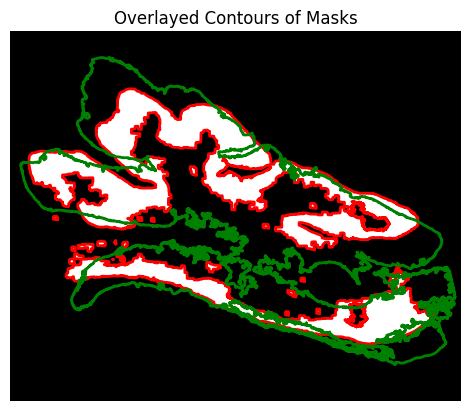

In [61]:
# Find contours for each mask
he_contours = find_contours(he, level=0.5)
melana_contours = find_contours(melana_rotated, level=0.5)

# Plot the base image (you can choose to use one of the images or any other background)
plt.imshow(he, cmap='gray')  # Replace `he` with the desired base image

# Plot contours of each mask on top of the base image
for contour in he_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red', lw=2)  # Red contours for H&E

for contour in melana_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='green', lw=2)  # Green contours for melana

# Customize plot (optional)
plt.title('Overlayed Contours of Masks')
plt.axis('off')  # Hide axis
plt.show()

### geojsons + team 1

In [63]:
def geojson_to_raster(geojson_path, out_shape=(1000, 1000)):
    gdf = gpd.read_file(geojson_path)
    if gdf.empty:
        print(f"GeoDataFrame is empty. Check the GeoJSON file at {geojson_path}")
        return None
    geometries = gdf.geometry
    # get the bounding box of the entire geometry
    minx, miny, maxx, maxy = geometries.total_bounds
    width = int(out_shape[1])  # the number of columns (horizontal pixels)
    height = int(out_shape[0])  # the number of rows (vertical pixels)
    transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)
    with rasterio.open('/dev/null', 'w', driver='GTiff', width=width, height=height, count=1, dtype='uint8', transform=transform) as dst:
        mask = geometry_mask(geometries, transform=dst.transform, invert=True, out_shape=(height, width))
    mask = (mask.astype(np.uint8)) * 255 
    return mask

def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

def pipeline_helper(geojson_path, out_shape=(1000, 1000)):
    mask = geojson_to_raster(geojson_path, out_shape)
    centered_mask = center_image(mask)
    return centered_mask

def pipeline(path1, path2, path3):
    mask1 = pipeline_helper(path1)
    mask2 = pipeline_helper(path2)
    mask3 = pipeline_helper(path3)

    # Step 1: Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1], mask3.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0], mask3.shape[0])

    # Step 2: Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))
    mask3 = pad_to_size(mask3, (max_width, max_height))

    # Step 3: Find the best rotation for mask2 that maximizes overlap with mask1
    best_overlap_2, angle2 = find_best_rotation(mask1, mask2)
    mask2_rotated = rotate_image(mask2, angle2)

    # Step 4: Find the best rotation for mask3 that maximizes overlap with the rotated mask2
    best_overlap_3, angle3 = find_best_rotation(mask1, mask3)
    mask3_rotated = rotate_image(mask3, angle3)
    
    return mask1, mask2, mask3, mask2_rotated, mask3_rotated, angle2, angle3 

In [15]:
paths = ['geojsons2/h&e_ROI_3.geojson', 'geojsons2/melan a_ROI_1.geojson', 'geojsons2/sox10_ROI_1.geojson']
he, melana, sox, melana_rotated, sox_rotated, angle2, angle3  = pipeline(paths[0], paths[1], paths[2])

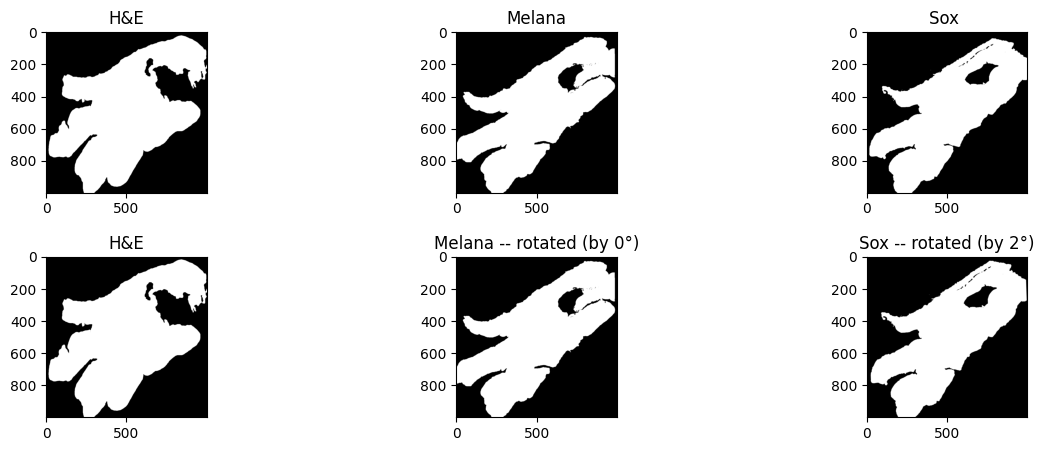

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 3, 1)
plt.title('H&E')
plt.imshow(he, cmap='gray')

plt.subplot(2, 3, 2)
plt.title(f'Melana')
plt.imshow(melana, cmap='gray')

plt.subplot(2, 3, 3)
plt.title(f'Sox ')
plt.imshow(sox, cmap='gray')

plt.subplot(2, 3, 4)
plt.title('H&E')
plt.imshow(he, cmap='gray')

plt.subplot(2, 3, 5)
plt.title(f'Melana -- rotated (by {angle2}°)')
plt.imshow(melana_rotated, cmap='gray')

plt.subplot(2, 3, 6)
plt.title(f'Sox -- rotated (by {angle3}°)')
plt.imshow(sox_rotated, cmap='gray')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.show()

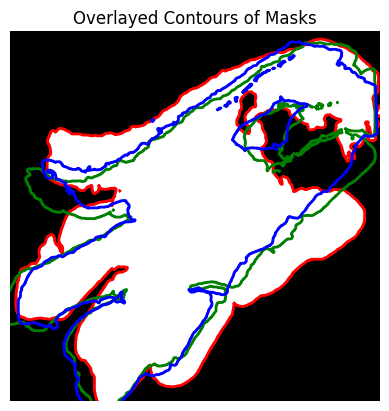

In [21]:
# Find contours for each mask
he_contours = find_contours(he, level=0.5)
melana_contours = find_contours(melana_rotated, level=0.5)
sox_contours = find_contours(sox_rotated, level=0.5)

# Plot the base image (you can choose to use one of the images or any other background)
plt.imshow(he, cmap='gray')  # Replace `he` with the desired base image

# Plot contours of each mask on top of the base image
for contour in he_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red', lw=2)  # Red contours for H&E

for contour in melana_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='green', lw=2)  # Green contours for melana

for contour in sox_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='blue', lw=2)  # Blue contours for Sox

# Customize plot (optional)
plt.title('Overlayed Contours of Masks')
plt.axis('off')  # Hide axis
plt.show()

In [64]:
def pipeline_adjusted(mask1, path2, path3):
    mask2 = pipeline_helper(path2)
    mask3 = pipeline_helper(path3)

    # Step 1: Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1], mask3.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0], mask3.shape[0])

    # Step 2: Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))
    mask3 = pad_to_size(mask3, (max_width, max_height))

    # Step 3: Find the best rotation for mask2 that maximizes overlap with mask1
    best_overlap_2, angle2 = find_best_rotation(mask1, mask2)
    mask2_rotated = rotate_image(mask2, angle2)

    # Step 4: Find the best rotation for mask3 that maximizes overlap with the rotated mask2
    best_overlap_3, angle3 = find_best_rotation(mask1, mask3)
    mask3_rotated = rotate_image(mask3, angle3)
    
    return mask1, mask2, mask3, mask2_rotated, mask3_rotated, angle2, angle3 

In [65]:
paths = ['geojsons2/h&e_ROI_3.geojson', 'geojsons2/melan a_ROI_1.geojson', 'geojsons2/sox10_ROI_1.geojson']
he, melana, sox, melana_rotated, sox_rotated, angle2, angle3  = pipeline_adjusted(he_ep_mask, paths[1], paths[2])

In [71]:
from skimage.measure import find_contours, label, regionprop

ImportError: cannot import name 'regionprop' from 'skimage.measure' (/Users/annie/Desktop/project/.venv/lib/python3.9/site-packages/skimage/measure/__init__.py)

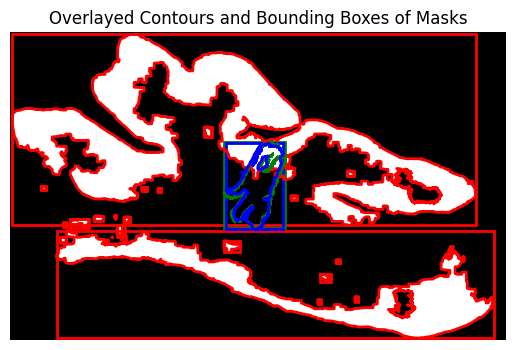

In [72]:
# Find contours for each mask
he_contours = find_contours(he, level=0.5)
melana_contours = find_contours(melana_rotated, level=0.5)
sox_contours = find_contours(sox_rotated, level=0.5)

# Plot the base image (you can choose to use one of the images or any other background)
plt.imshow(he, cmap='gray')  # Replace `he` with the desired base image

# Plot contours of each mask on top of the base image
for contour in he_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='red', lw=2)  # Red contours for H&E

for contour in melana_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='green', lw=2)  # Green contours for melana

for contour in sox_contours:
    plt.plot(contour[:, 1], contour[:, 0], color='blue', lw=2)  # Blue contours for Sox

# Plot bounding boxes for each mask
def plot_bounding_boxes(mask, color):
    # Label connected components (objects) in the mask
    labeled_mask = label(mask)
    
    # Find properties of the labeled regions
    regions = regionprops(labeled_mask)
    
    for region in regions:
        minr, minc, maxr, maxc = region.bbox  # Bounding box: (min_row, min_col, max_row, max_col)
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, 
                             linewidth=2, edgecolor=color, facecolor='none')
        plt.gca().add_patch(rect)

# Plot bounding boxes for each mask (red, green, blue)
plot_bounding_boxes(he, color='red')
plot_bounding_boxes(melana_rotated, color='green')
plot_bounding_boxes(sox_rotated, color='blue')

# Customize plot (optional)
plt.title('Overlayed Contours and Bounding Boxes of Masks')
plt.axis('off')  # Hide axis
plt.show()
